In [1]:
# !pip install chromadb google-genai langchain-text-splitters python-dotenv gitpython tqdm

In [2]:
!pip install matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import glob
import time
import chromadb
from git import Repo
from dotenv import load_dotenv

from langchain_text_splitters import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from google import genai
from tqdm import tqdm

import PIL.Image
import re

from google.genai import types

from IPython.display import display, Image


# Configuration & Cloning

In [4]:

load_dotenv()


REPO_URL = "https://github.com/mkdocs/mkdocs.git"
CLONE_DIR = "mkdocs_repo"  
DOCS_DIR = os.path.join(CLONE_DIR, "docs", "user-guide")
DB_PATH = "mkdocs_db"


if not os.path.exists(CLONE_DIR):
    Repo.clone_from(REPO_URL, CLONE_DIR)
    print("Cloning completed")

# Text Cleaning Function

In [5]:
def clean_content(text):
    # 1. Remove MkDocs Directives
    text = re.sub(r'^:{3,}.*$', '', text, flags=re.MULTILINE)
    # 2. Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # 3. Remove artifacts
    text = text.replace('&nbsp;', ' ')
    text = re.sub(r'--8<--\s*".*?"', '', text)
    return text

# Chunking

I chose **MarkdownHeaderTextSplitter** because MkDocs documentation is highly structured. 
Splitting by headers (#, ##, ###) ensures that a topic and its content stay together contextually, rather than 
breaking mid-sentence or mid-code-block which often happens with simple character splitting.

In [6]:
# Chunking Strategy
headers_to_split_on = [("#", "Header 1"),("##", "Header 2"),("###", "Header 3")]
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

documents = []
metadatas = []
ids = []

md_files = glob.glob(f"{DOCS_DIR}/**/*.md", recursive=True)
print(f"Found {len(md_files)} markdown files.")

for file_path in md_files:
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()

    content = clean_content(content)
    content = content.replace("\n\n\n", "\n\n")

    header_splits = markdown_splitter.split_text(content)
    final_splits = text_splitter.split_documents(header_splits)

    rel_path = os.path.relpath(file_path, DOCS_DIR)

    for i, split in enumerate(final_splits):

        documents.append(split.page_content)
    

        meta = {"source": rel_path, "chunk_id": i, "type": "text"}
        meta.update(split.metadata)
        metadatas.append(meta)
        ids.append(f"{rel_path}_{i}")

print(f"Created {len(documents)} text chunks.")

Found 9 markdown files.
Created 145 text chunks.


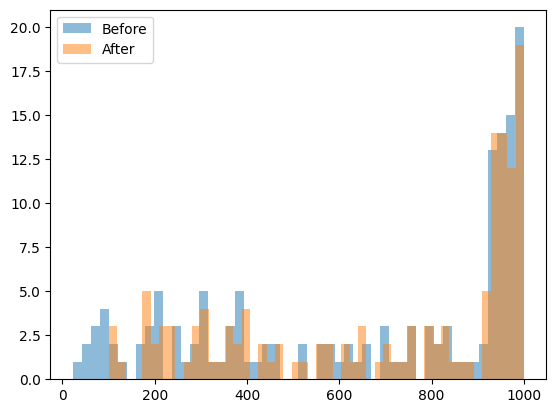

Cleaned! Now have 136 chunks.


In [7]:
import matplotlib.pyplot as plt

# 1. Filter: Keep only chunks >= 100 chars
THRESHOLD = 100
# Combine lists, filter, and unzip back into separate lists
filtered = [(d, m, i) for d, m, i in zip(documents, metadatas, ids) if len(d) >= THRESHOLD]
new_docs, new_meta, new_ids = zip(*filtered)

# 2. Simple Plot: Show Before (Blue) and After (Orange)
plt.hist([len(d) for d in documents], bins=50, alpha=0.5, label='Before')

plt.hist([len(d) for d in new_docs], bins=50, alpha=0.5, label='After')
plt.legend()
plt.show()

# 3. Update your main variables
documents, metadatas, ids = list(new_docs), list(new_meta), list(new_ids)
print(f"Cleaned! Now have {len(documents)} chunks.")

# Database Initialization

In [8]:
client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
chroma_client = chromadb.PersistentClient(path=DB_PATH)

if "MkDocs_Guides" in [c.name for c in chroma_client.list_collections()]:
    chroma_client.delete_collection("MkDocs_Guides")

collection = chroma_client.get_or_create_collection(name="MkDocs_Guides")


# Embed and Store Text

In [9]:
batch_size = 50
total_chunks = len(documents)

print("Embedding Text Chunks...")
for i in tqdm(range(0, total_chunks, batch_size)):
    end = min(i + batch_size, total_chunks)
    batch_docs = documents[i:end]
    batch_meta = metadatas[i:end]
    batch_ids = ids[i:end]

    # Generate Embeddings
    response = client.models.embed_content(model="text-embedding-004", contents=batch_docs)
    batch_embeddings = [e.values for e in response.embeddings]

    # Add to Chroma
    collection.add(documents=batch_docs, embeddings=batch_embeddings, metadatas=batch_meta, ids=batch_ids)
    time.sleep(1.5) 

print("Text indexing complete.")

Embedding Text Chunks...


100%|██████████| 3/3 [00:07<00:00,  2.61s/it]

Text indexing complete.


# Multimodal Image Processing

In [10]:

IMG_DIR = os.path.join(CLONE_DIR, "docs")
image_files = glob.glob(f"{IMG_DIR}/**/*.png", recursive=True) + \
              glob.glob(f"{IMG_DIR}/**/*.jpg", recursive=True) + \
              glob.glob(f"{IMG_DIR}/**/*.jpeg", recursive=True)

print(f"Found {len(image_files)} images.")

for img_path in tqdm(image_files, desc="Captioning Images"):
    try:
        img = PIL.Image.open(img_path)

        # 1. Vision: Get description
        prompt = "Analyze this image from the MkDocs documentation. Describe exactly what it shows (UI elements, code snippets, or diagrams) in detail so a user can search for it."
        response = client.models.generate_content(model="gemini-2.0-flash", contents=[img, prompt])
        image_description = response.text

        # 2. Embed description
        embed_response = client.models.embed_content(model="text-embedding-004", contents=image_description)
        embedding = embed_response.embeddings[0].values

        # 3. Store with image path in metadata
        rel_path = os.path.relpath(img_path, ".") # Keep full relative path for app display

        collection.add(
            documents=[image_description],
            embeddings=[embedding],
            metadatas=[{"source": rel_path, "type": "image"}],
            ids=[f"image_{rel_path}"]
        )
        time.sleep(2)

    except Exception as e:
        print(f"Skipped {img_path}: {e}")

print("All Data Ingested Successfully!")

Found 10 images.


Captioning Images: 100%|██████████| 10/10 [01:10<00:00,  7.01s/it]

All Data Ingested Successfully!


In [11]:

def query_mkdocs(question):
    response = client.models.embed_content( model="text-embedding-004", contents=question )
    query_embedding = response.embeddings[0].values

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=5  # k=5 , 5 text chunks that are mathematically closest to this question
    )

    context_docs = results["documents"][0]
    sources = set([m["source"] for m in results["metadatas"][0]])
    context_text = "\n\n---\n\n".join(context_docs)


    print("\n" + "="*70)
    print(f"QUESTION: {question}")
    print(f"RETRIEVED CONTEXT:\n{context_text}")
    print("="*70 + "\n")


    system_instruction = """You are a specialized Technical Support Assistant for MkDocs.
    STRICT RULES:
    1. Answer using ONLY the provided context.
    2. If the answer is NOT in the context, say: "I cannot find information about this in the MkDocs documentation."
    3. Keep answers technical and concise."""

    user_message = f"""Context:
    {context_text}

    Question: {question}"""

    response = client.models.generate_content(model="gemini-2.0-flash",contents=user_message,
        config=types.GenerateContentConfig(
            system_instruction=system_instruction,
            temperature=0.3
        )
    )
    return response.text, sources


## Test

AI Answer: Based on the provided documentation and the image description, here's how to enable the dark theme:

**Using the UI (as shown in the image):**

1.  **Locate the theme selector:** Look for a crescent moon icon (or a sun icon if the light theme is currently active) usually found in the top right corner of the website.
2.  **Open the dropdown menu:** Click on the icon to open the theme selection dropdown.
3.  **Select "Dark":**  In the dropdown menu, click on the "Dark" option (the one with the crescent moon icon). A checkmark should appear next to "Dark" to confirm your selection.

**Using the `mkdocs.yml` configuration file:**

While the image shows a UI element for theme selection, the documentation focuses on setting the theme within the `mkdocs.yml` configuration file.  If you want the site to *default* to dark mode, you'll need to find a theme that supports configuration for dark mode and set that configuration in `mkdocs.yml`.  The documentation doesn't provide explicit 

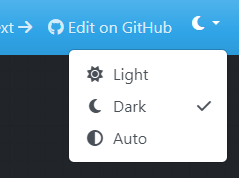

In [12]:

question = " how to make dark theame ?"

query_vec = client.models.embed_content(model="text-embedding-004", contents=question).embeddings[0].values
results = collection.query(query_embeddings=[query_vec], n_results=5)

context_text = "\n\n".join(results["documents"][0])
prompt = f"Context:\n{context_text}\n\nQuestion: {question}\nAnswer:"
response = client.models.generate_content(model="gemini-2.0-flash", contents=prompt)

print(f"AI Answer: {response.text}\n")

image_found = False
for meta in results["metadatas"][0]:
    source = meta['source']
    if source.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(Image(filename=source, width=500))
        image_found = True

if not image_found:
    print("No images found for this specific question.")

In [13]:
question1 = "How do I enable the readthedocs theme?"
response, sources = query_mkdocs(question1)
print(f"{'*'*70}\nAI Answer: {response}\n{'*'*70}\n\n\n")


question2 = "What is the capital of France?"
response, sources = query_mkdocs(question2)
print(f"{'*'*70}\nAI Answer: {response}\n{'*'*70}\n\n\n")



QUESTION: How do I enable the readthedocs theme?
RETRIEVED CONTEXT:
Selecting and configuring a theme.  
---  
MkDocs includes two built-in themes ([mkdocs](#mkdocs) and
[readthedocs](#readthedocs)), as documented below. However, many [third party
themes] are available to choose from as well.  
To choose a theme, set the [theme] configuration option in your `mkdocs.yml`
config file.  
```yaml
theme:
name: readthedocs
```

---

For theme localization to work, you must use a theme which supports it and
enable `i18n` (internationalization) support by installing `mkdocs[i18n]`:  
```bash
pip install 'mkdocs[i18n]'
```

---

A clone of the default theme used by the [Read the Docs] service, which offers
the same restricted feature set as its parent theme. Like its parent theme, only
two levels of navigation are supported.  
![ReadTheDocs](../img/readthedocs.png)  
In addition to the default [theme configuration options][theme], the `readthedocs`
theme supports the following options:  
*   *